In [226]:
# Modules

# Arrays and handling data
import numpy as np
import pandas as pd

from astropy.io import fits # Astronomical files
from astropy.wcs import WCS # Converting between pixels and WCS

# Plotting data
import matplotlib
from matplotlib import pyplot as plot

 # Pulling data
import requests
#import urllib.request
import json
from urllib.parse import quote as urlencode   

# Accessing local files
#import sys
#import io

#import time # Timers and waiting

from photutils.aperture import CircularAperture # Creating apertures
#from astropy.coordinates import SkyCoord

In [288]:
# Getting ra, dec and radius from TIC ID from the TIO Catalog

tic_ID = "TIC 155657581" # SIMBAD4 flickers really brightly so it should be easy to spot

ra = "206.395293725348"
dec = "79.3967479665581"
radius = "0.1" # Probably search radius

In [290]:
# Query using MAST to get the cutout and all the stars inside the cutout

def mast_query(request):
    request_url='https://mast.stsci.edu/api/v0/invoke' # Base URL
    
    version = ".".join(map(str, sys.version_info[:3])) # Grab Python version
 
    headers = { # Create HTTP header variables
        "Content-type": "application/x-www-form-urlencoded",
        "Accept": "text/plain",
        "User-agent": "python-requests/" + version
    }
    
    # Encoding the request as a JSON string
    
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    response = requests.post(request_url, data = "request=" + req_string, headers = headers) # Perform the HTTP request
    
    # Pull out the headers and response content
    head = response.headers # Content where head is the response HTTP headers
    content = response.content.decode('utf-8') # Returned data
    
    return head, content

'''
def tic_cone_search():
    request = {
        "service": "Mast.Catalogs.Tic.Cone",
        "params": {
            "ra": ra,
            "dec": dec,
            "radius": radius
        },
        "format":"json",
        "timeout": 10
    }   
    
    headers, out_string = mast_query(request)
    out_data = json.loads(out_string)
    return out_data
'''

def tic_advanced_search_position_rows():
    request = {"service": "Mast.Catalogs.Filtered.Tic.Position.Rows",
               "format": "json",
               "params": {
                   "columns": "ID, ra, dec",
                   "filters": [],
                   "ra": ra,
                   "dec": dec,
                   "radius": radius
               }}
 
    headers, out_string = mast_query(request)
    out_data = json.loads(out_string)
    
    dataframe = pd.DataFrame(out_data["data"])
    
    return dataframe #out_data

cone = tic_advanced_search_position_rows() #tic_advanced_search_position() # Now a dataframe

In [281]:
def get_ZTF_links(ra, dec, cutout_size): # Download the ZTF image
    pd.set_option("display.max_columns", None)
    
    metadata_URL = "https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci?POS=" + str(ra) + "," + str(dec)
    metadata_response = requests.get(metadata_URL)
    save_table_name = "ogfile.txt"
    open(save_table_name, "wb").write(metadata_response.content)
    
    table = ""
    with open(save_table_name) as saved_table_file:
        lines = saved_table_file.readlines()
        headers = lines[90].replace(" ", "").split("|")[1:-1]
        headers.insert(19, "obstime") # Adding the times which are separated by spaces so pandas can use " " as a delimeter
        headers.insert(45, "ipac_pub_time")
        
        table = pd.read_table(save_table_name, skiprows = 94, names = headers, delim_whitespace = True) # After row 94 is the data, but 91 is the header
    
    fits_URLs = []
    #picture_number = 0
    for picture_number in range(0, 20):
        file_fracday = str(table.at[picture_number, "filefracday"]) # yyyy + mm + dd + fracday
        year = str(file_fracday[:4]) # yyyy
        month = str(file_fracday[4:6]) # mm
        day = str(file_fracday[6:8]) # dd
        fracday = str(file_fracday[8:])
        padded_field = str("000" + str(table.at[picture_number, "field"])) # 000 + field
        filter_code = str(table.at[picture_number, "filtercode"])
        padded_ccdid = str(table.at[picture_number, "ccdid"]) # ccdid
        image_type_code = str(table.at[picture_number, "imgtypecode"]) # imgtypecode
        qid = str(table.at[picture_number, "qid"])
        suffix = "sciimg.fits" # Primary science image
        
        fits_URL = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/" + str(year) + "/" + str(month) + str(day) + "/" + str(fracday) + "/ztf_" + str(file_fracday) + "_" + str(padded_field) + "_" + str(filter_code) + "_c" + str(padded_ccdid) + "_" + str(image_type_code) + "_q" + str(qid) + "_" + str(suffix) # Entire .fits file
        if not cutout_size == "":
            fits_URL += "?center=" + str(ra) + "," + str(dec) + "&size=" + str(cutout_size) + "arcsec&gzip=false" # For downloading .fits cutout
        #response = requests.get(str(fits_URL)) # I don't need the URL results because fits can open right from the URL
        fits_URLs.append(fits_URL)
    
    return fits_URLs

def open_ZTF(fits_URL): # Open the ZTF image
    plot.figure(figsize = (10, 10)) # Sizing plot to be larger (and therefore clearer on the screen)
    file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file
    fits_image = np.array(file[0].data)
    print(fits_image.shape)
    
    # Plotting the image itself
    plot.imshow(np.flipud(fits_image), norm = matplotlib.colors.LogNorm()) # Log color scale to more easily see the contrast and see more stars. FLip the image data vertically to check with ds9
    colorbar = plot.colorbar() # Display the colorbar
    colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
    colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
    
    # Plotting the lightcurve

146
['https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0710/238368/ztf_20200710238368_000862_zg_c14_o_q2_sciimg.fits?center=205.974761352481,79.4034939903583&size=30arcsec&gzip=false', 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0711/326343/ztf_20200711326343_000862_zi_c14_o_q2_sciimg.fits?center=205.974761352481,79.4034939903583&size=30arcsec&gzip=false', 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0713/245347/ztf_20200713245347_000862_zr_c14_o_q2_sciimg.fits?center=205.974761352481,79.4034939903583&size=30arcsec&gzip=false', 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0713/202431/ztf_20200713202431_000862_zg_c14_o_q2_sciimg.fits?center=205.974761352481,79.4034939903583&size=30arcsec&gzip=false', 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0731/263241/ztf_20200731263241_000862_zr_c14_o_q2_sciimg.fits?center=205.974761352481,79.4034939903583&size=30arcsec&gzip=false', 'https://irsa.ipac.caltech.edu/ibe/

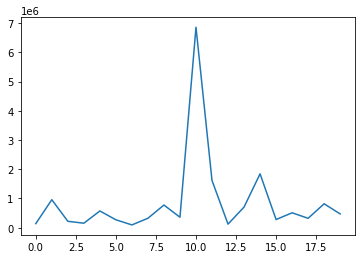

In [292]:
#open("cone2.txt", "w").write(str(cone)) # Save the cone as a file because it is too large
#print(cone.head())
print(len(cone))

#for star_index in cone
star_index = 0#28203 # Take the SIMBAD star
#cone[star_index]
#print(cone.loc[cone["ID"] == 155657581]) # IS A NUMBER NOT STRING, column 28203
cutout_size = "30" # In arcseconds
fits_URLs = get_ZTF_links(str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
print(fits_URLs)

brightnesses = []
for fits_URL in fits_URLs:
    print(fits_URL)
    fits_file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file
    fits_image = np.array(fits_file[0].data)
    brightnesses.append(np.sum(fits_image))
    fits_file.close()



plot.plot(np.arange(0, 20), brightnesses)
#open_ZTF(fits_URL)

In [183]:
header = file[0].header #fits.getheader(file)
w = WCS(header)
wx, wy = w.wcs_pix2world(100., 99., 1)
print('{0} {1}'.format(wx, wy))

255.65237941161257 11.831369947109241


In [284]:
print(brightnesses)

[211275.88, 1015384.6, 421601.7, 216696.16, 846886.0, 524962.8, 158864.25, 573345.1, 1143076.4, 545978.2, 7437469.0, 1728341.2, 189894.28, 731922.4, 3102312.2, 686407.8, 546331.7, 329324.12, 838857.6, 523581.4]


In [188]:
base_url = "https://fallingstar-data.com/forcedphot"
%run Passwords.ipynb

response = requests.post(url = str(base_url) + "/api-token-auth/", data = {"username": username, "password": password})
ra = 44
dec = 22
task_url = ""

if response.status_code == 200:
    token = response.json()["token"]
    print("Token: " + str(token))
    headers = {"Authorization": "Token " + str(token), "Accept": "application/json"}
    
    task_url = None
    while not task_url:
        with requests.Session() as session:
            response = session.post(str(base_url) + "/queue/", headers = headers, data = {"ra": ra, "dec": dec, "mjd_min": 59248., "send_email": False})
            
            if response.status_code == 201:  # Successfull!
                task_url = response.json()["url"]
                print("Task URL: " + str(task_url))
                
                response = requests.get(task_url, allow_redirects = True)
                open("test.txt", "wb").write(response.content)
            elif response.status_code == 429:  # Wait
                message = response.json()["detail"]
                print("ERROR: " + str(response.status_code))
                print(response.json())
                seconds = re.findall(r'available in (\d+) seconds', message)
                minutes = re.findall(r'available in (\d+) minutes', message)
                wait_time = 0
                if t_sec:
                    wait_time = int(seconds[0])
                elif t_min:
                    wait_time = int(minutes[0]) * 60
                else:
                    wait_time = 10
                print("Waiting " + str(wait_time) + " seconds...")
                time.sleep(wait_time)
            else: # Fail
                print("ERROR: " + str(response.status_code))
                print(response.json())
                sys.exit()
else:
    print("ERROR: " + str(response.status_code))
    print(response.json())

Token: 5cce47d2becf05b9142e13afd79c6648da9b26db
Task URL: https://fallingstar-data.com/forcedphot/queue/215932/


In [35]:
result_url = None
while not result_url:
    with requests.Session() as session:
        response = session.get(task_url, headers = headers)
        
        if response.status_code == 200: # HTTP OK
            if response.json()["finishtimestamp"]:
                result_url = response.json()["result_url"]
                print("Result URL: " + str(result_url))
                break
            elif response.json()["starttimestamp"]:
                print("Task is running (started at " + str(response.json()["starttimestamp"]))
            else:
                print("Waiting 10 seconds...")
                time.sleep(10)
        else:
            print("ERROR: " + str(response.status_code))
            print(response.json())
            sys.exit()


panda_result = ""

with requests.Session() as session:
    textdata = session.get(result_url, headers = headers).text
    #print(textdata)
    
    session.delete(task_url, headers = headers).json() # De-clutter sessions
    
    panda_result = pd.read_csv(io.StringIO(textdata.replace("###", "")), delim_whitespace = True)
    print(panda_result)

Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...


ConnectionError: HTTPSConnectionPool(host='fallingstar-data.com', port=443): Max retries exceeded with url: /forcedphot/queue/215366/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000222E26E2610>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))